## Подготовим данные из kaggle с помощью API.

In [1]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!pip install tensorflow_addons
!pip install umap-learn
#!pip install scann
! pip install tensorflow==2.4.1

Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 1.6MB 4.1MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
     |████████████████████████████████| 58 kB 2.8 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72857 sha256=13ad9a0b1d8af94d7a88bc7f5a1ea6372e56bc7302e42a354bf289ebceb04d6a
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
     |████████████████████████████████| 679 kB 4.1 MB/s 
     |████████████████████████████████| 80 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 7.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=63082e1e9dc699d7d6fc5b119420ac1d582e17274b07b02dbb02c3878c27eced
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a

In [2]:
!pwd
!mkdir ~/.kaggle
!echo '{"username":"polololya","key":"1f4ad1fc8a1535e236393da48a325aa8"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!cat ~/.kaggle/kaggle.json

/content
{"username":"polololya","key":"1f4ad1fc8a1535e236393da48a325aa8"}


In [3]:
!kaggle competitions download -c shopee-product-matching
!mkdir shopee-product-matching
!unzip -qq shopee-product-matching.zip -d shopee-product-matching

100% 1.68G/1.68G [00:24<00:00, 34.2MB/s]
100% 1.68G/1.68G [00:24<00:00, 73.2MB/s]


In [4]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b3.tar.gz
!wget https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
!tar -xf noisy_student_efficientnet-b3.tar.gz
!python efficientnet_weight_update_util.py --model b3 --notop --ckpt noisy-student-efficientnet-b3/model.ckpt --o efficientnetb3_notop.h5

--2021-06-15 15:58:11--  https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b3.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.203.128, 74.125.204.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90666978 (86M) [application/gzip]
Saving to: ‘noisy_student_efficientnet-b3.tar.gz’

noisy_student_effic 100%[===================>]  86.47M   170MB/s    in 0.5s    

2021-06-15 15:58:12 (170 MB/s) - ‘noisy_student_efficientnet-b3.tar.gz’ saved [90666978/90666978]

--2021-06-15 15:58:12--  https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/python/keras/applications/efficientnet_weight_update_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.git

## Подготовим данные и построим модель

In [23]:
import io, os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow.keras as keras
import tensorflow as tf
import tensorflow_addons as tfa
# import tensorflow_datasets as tfds
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [6]:
all_train_df = pd.read_csv('/content/shopee-product-matching/train.csv')
test_df = pd.read_csv('/content/shopee-product-matching/test.csv')

all_train_df['image'] = '/content/shopee-product-matching/train_images/' + all_train_df['image']
test_df['image'] = '/content/shopee-product-matching/test_images/' + test_df['image']

all_train_df.sort_values(by='label_group', inplace=True)
all_train_df.head()

,posting_id,image,image_phash,title,label_group
3874,train_1646767365,/content/shopee-product-matching/train_images/...,e925873ed09cd08f,Sarung celana wadimor original 100% dewasa dan...,258047
31859,train_1528423085,/content/shopee-product-matching/train_images/...,ea97861c926a71e3,WARNA RANDOM ACAK Sarung Celana Wadimor MURAH ...,258047
6738,train_398181303,/content/shopee-product-matching/train_images/...,e9b5833e929e909c,SARUNG CELANA WADIMOR DEWASA HITAM POLOS SARCEL,258047
7613,train_2865605743,/content/shopee-product-matching/train_images/...,bfc3cc1cc636c14c,Wall Sticker / WallSticker - Submarine Measur...,297977
12367,train_1382500866,/content/shopee-product-matching/train_images/...,838436c07dff19e4,RELIZA WALL STICKER PENGUKUR TINGGI BADAN JERA...,297977


In [18]:
all_train_df.label_group.nunique()

11014

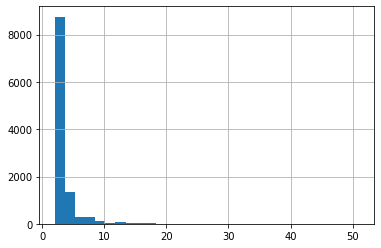

In [28]:
all_train_df.groupby('label_group').size().hist(bins=30)

In [30]:
all_train_df.label_group.unique()

array([    258047,     297977,     645628, ..., 4292939171, 4293276364,
       4294197112])

In [35]:
random_class = all_train_df.label_group.unique()[1000]
images = all_train_df.image[all_train_df.label_group == random_class].values

In [36]:
images

array(['/content/shopee-product-matching/train_images/bf79cb5b0a521a3ef11da563ab3f4018.jpg',
       '/content/shopee-product-matching/train_images/f2482617ede4c1c8da393839bda3dc8c.jpg',
       '/content/shopee-product-matching/train_images/77a51f6038d9c1f0559199a7f87228b4.jpg',
       '/content/shopee-product-matching/train_images/050c3f3a2da6d14713e09501d6fb9902.jpg',
       '/content/shopee-product-matching/train_images/4421287374831e7ab3801babeb8294a4.jpg',
       '/content/shopee-product-matching/train_images/4421287374831e7ab3801babeb8294a4.jpg',
       '/content/shopee-product-matching/train_images/4421287374831e7ab3801babeb8294a4.jpg',
       '/content/shopee-product-matching/train_images/842760ca2112a99100e02e3866fcd622.jpg',
       '/content/shopee-product-matching/train_images/43ed9d703eae677fc46ab6581c1c55e7.jpg'],
      dtype=object)

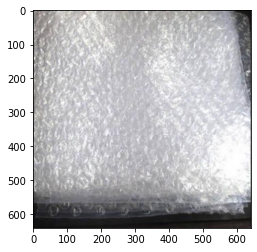

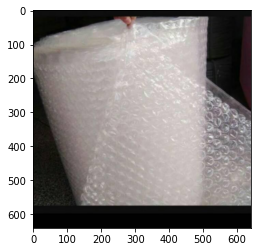

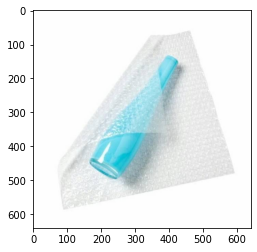

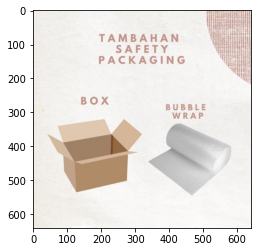

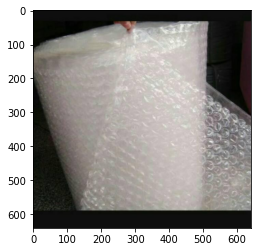

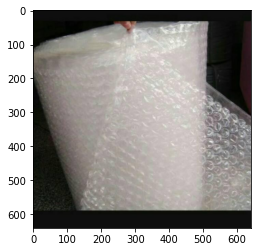

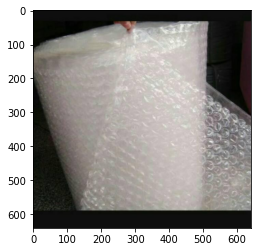

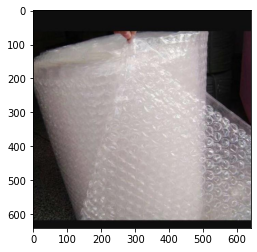

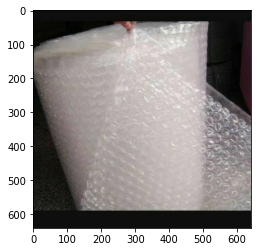

In [34]:

for image in images:
  img = cv2.imread(image) 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img);
  plt.show();

In [7]:
from sklearn.model_selection import GroupShuffleSplit
splitter = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(all_train_df, groups=all_train_df.label_group))
train_df = all_train_df.iloc[train_idx]
val_df = all_train_df.iloc[val_idx]

train_df.head()

,posting_id,image,image_phash,title,label_group
7613,train_2865605743,/content/shopee-product-matching/train_images/...,bfc3cc1cc636c14c,Wall Sticker / WallSticker - Submarine Measur...,297977
12367,train_1382500866,/content/shopee-product-matching/train_images/...,838436c07dff19e4,RELIZA WALL STICKER PENGUKUR TINGGI BADAN JERA...,297977
15610,train_2070644662,/content/shopee-product-matching/train_images/...,8a71617a016e1efd,LVN COLLAGEN - ORIGINAL TERMURAH - LVN STROBER...,645628
32085,train_2149563017,/content/shopee-product-matching/train_images/...,d5d4231fd2688d17,LVN COLLAGEN LVN STROBERI ORIGINAL 100% 1BOX I...,645628
27972,train_2419208039,/content/shopee-product-matching/train_images/...,c89817483f3f398e,LVN COLLAGEN / STROBERI,645628


In [8]:
train_df.shape, val_df.shape

((27188, 5), (7062, 5))

In [ ]:
train_df.

In [13]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
image_size = (300, 300)
BATCH_SIZE = 64

datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                             horizontal_flip=True,
                             zoom_range=[0.5, 1.0],
                             height_shift_range = 0.1,
                             width_shift_range = 0.1,
                             rotation_range=90,
                             brightness_range=[0.5,1.0]
                             )

params = dict(x_col="image",
              y_col="label_group",
              class_mode='raw',
              target_size=image_size,
              batch_size=BATCH_SIZE,
              shuffle=False)

train_generator = datagen.flow_from_dataframe(dataframe=train_df, **params)
val_generator = datagen.flow_from_dataframe(dataframe=val_df, **params)

Found 27188 validated image filenames.
Found 7062 validated image filenames.


In [14]:
from tensorflow.keras.layers import Dense, Lambda, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

EMBEDDING_SIZE = 256

backbone_model = EfficientNetB3(weights="efficientnetb3_notop.h5", include_top=False, pooling='avg')
# TODO: Linear(512) + BN + PReLU

backbone_model.trainable = False
for layer in backbone_model.layers[-32:]: # 20
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True

# for layer in backbone_model.layers:
#   if isinstance(layer, keras.layers.BatchNormalization):
#     layer.trainable = False
x = backbone_model.output

x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)

model_embedding_raw = Dense(EMBEDDING_SIZE, activation='linear')(x)
model_embedding_normalized = Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(model_embedding_raw)

embedding_model = Model(backbone_model.inputs, model_embedding_normalized)

embedding_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001), # 0.001
    loss=tfa.losses.TripletSemiHardLoss())

In [17]:
embedding_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
____________________________________________________________________________________________

In [ ]:
class GroupShufflerV2():
  def __init__(self, df, group_col):
    self.groups = [df for _, df in df.groupby(group_col)]

  def sample(self, max_samples_per_group=5):
    np.random.shuffle(self.groups)

    groups = self.groups
    if max_samples_per_group is not None:
      groups = [x.sample(min(len(x), max_samples_per_group)) for x in groups]

    return pd.concat(groups)

In [15]:
# val_loss: 0.3758

EPOCHS = 20
group_shuffler = GroupShufflerV2(train_df, 'label_group')

#for _ in range(EPOCHS):
  #train_generator = datagen.flow_from_dataframe(dataframe=group_shuffler.sample(max_samples_per_group=5), **params)
  
history = embedding_model.fit(train_generator,
                                  validation_data=val_generator, 
                                  epochs=EPOCHS, 
                                  steps_per_epoch = np.ceil(train_df.shape[0]/BATCH_SIZE),
                                  validation_steps=np.ceil(val_df.shape[0]/BATCH_SIZE))

Epoch 1/20
907/907 [==============================] - ETA: 0s - batch: 453.0000 - size: 29.9757 - loss: 0.7399

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


907/907 [==============================] - 1136s 1s/step - batch: 453.0000 - size: 29.9757 - loss: 0.7399 - val_loss: 0.8386
Epoch 2/20
907/907 [==============================] - 1110s 1s/step - batch: 453.0000 - size: 29.9757 - loss: 0.6480 - val_loss: 0.9245
Epoch 3/20
907/907 [==============================] - 1106s 1s/step - batch: 453.0000 - size: 29.9757 - loss: 0.6184 - val_loss: 0.8646
Epoch 4/20
907/907 [==============================] - 1104s 1s/step - batch: 453.0000 - size: 29.9757 - loss: 0.5964 - val_loss: 0.9051
Epoch 5/20
907/907 [==============================] - 1111s 1s/step - batch: 453.0000 - size: 29.9757 - loss: 0.5829 - val_loss: 0.9213
Epoch 6/20
225/907 [======>.......................] - ETA: 10:37 - batch: 112.0000 - size: 29.9022 - loss: 0.5682

KeyboardInterrupt: ignored

In [ ]:
# 0.278

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

params = dict(x_col="image",
              y_col="label_group",
              class_mode='raw',
              target_size=(450, 450),
              batch_size=30,
              shuffle=False)

#train_generator = datagen.flow_from_dataframe(dataframe=train_df, **params)
val_generator = datagen.flow_from_dataframe(dataframe=val_df, **params)

embedding_model.evaluate(val_generator)

In [ ]:
import cv2

In [ ]:
img = cv2.imread()

In [ ]:
embedding_model.predict()

### Тест

inference is better at (400, 400)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tqdm.auto import tqdm

def predict_for_dataset(model, images):
  predictions = list()
  for batch in tqdm(np.array_split(images, len(images)//BATCH_SIZE)):
    batch_data = np.vstack([np.array(preprocess_input(load_img(img_path).resize(image_size)))[np.newaxis] for img_path in batch])
    predictions.append(model.predict(batch_data))
  return np.vstack(predictions)

val_embeddings = predict_for_dataset(embedding_model, val_df.image)

In [ ]:
val_embeddings.shape

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
val_embeddings = pd.DataFrame(val_embeddings, index=val_df.label_group)

In [ ]:
evaluation = {}
for idx, embedding in val_embeddings.iterrows():
  similarities = cosine_similarity(val_embeddings, embedding.values.reshape(1,-1))
  similarities = pd.DataFrame(similarities, index=val_embeddings.index, columns=['sim']).sort_values('sim',ascending=False)
  top5 = similarities.iloc[1:6].index.values
  evaluation[idx] = top5


{258047: array([2647556796,  819047038, 2836108778, 2836108778, 1272580494]),
 801176: array([    801176, 2106621791, 1261987196, 4234755890, 1822865877]),
 4063438: array([   4063438, 2935813666, 2935813666, 3326267479, 2935813666]),
 4340963: array([ 281151013, 1828551048,  281151013,  281151013,  281151013]),
 6381662: array([   6381662, 2332367334, 2813878058, 2669529988, 2905279378]),
 9784494: array([   9784494, 1130629555, 1130629555, 1130629555,  500429675]),
 11497208: array([2071468974, 3060733195, 3060733195, 2864178368, 3924467683]),
 14108831: array([2590814421, 2590814421, 1998950974, 4046299305, 1112224173]),
 15630034: array([  15630034,  535175311, 3360522898, 1130629555, 2203998632]),
 16448490: array([16448490, 16448490, 16448490, 16448490, 16448490]),
 16933527: array([16933527, 16933527, 16933527, 16933527, 16933527]),
 16993220: array([ 986496525, 2373193017,  574360295, 1698326880,  954950473]),
 18264600: array([18264600, 18264600, 46447054, 18264600, 18264600])

In [ ]:
top5_recall = 0
for key, value in evaluation.items():
  top5_recall += sum([1 if key == value[idx] else 0 for idx in range(5)])/5
top5_recall = top5_recall / len(evaluation)

In [ ]:
top5_recall

0.16250567408079683

In [ ]:
from umap import UMAP
dim_reductor = UMAP(metric='cosine')
dim_reductor.fit(val_embeddings)

UMAP(a=None, angular_rp_forest=True, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='cosine', metric_kwds=None,
     min_dist=0.1, n_components=2, n_epochs=None, n_jobs=-1, n_neighbors=15,
     negative_sample_rate=5, output_dens=False, output_metric='euclidean',
     output_metric_kwds=None, random_state=None, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, ...)

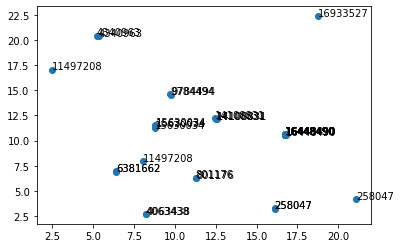

In [ ]:
import matplotlib.pylab as plt


X_images_embeddings_2d = dim_reductor.transform(val_embeddings[:30])
y_label = val_df.iloc[:30].label_group

plt.scatter(X_images_embeddings_2d[:,0], X_images_embeddings_2d[:,1], label=y_label)

for (x,y), text in zip(X_images_embeddings_2d, y_label): 
  plt.text(x, y, text)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
embedding_model.save('/content/drive/MyDrive/shared/NoisyEfficientNetB3__avg__256__zoom_flip__max3samples.h5')